In [1]:
## Questa è l'analisi preliminare eseguita sui dati
## Elimina i dati registrati da misurazioni sbagliate o imprecise
## Aumenta il dataset con dati derivati a partire da dati presenti

# Ciao

In [2]:
## import librerie

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import LineString


In [3]:
## creazione df

df1= pd.read_csv("data/gps-22-12-2024.csv",
    usecols=[0, 1, 2, 3, 6 ,7], 
    names=["unixtime", "latitudine", "longitudine", "altitudine", "precisione_orizzontale", "precisione_verticale"] ## 
    )

## righe duplicate in unixtime
df1 = df1[df1.duplicated(subset="unixtime", keep='first') == False]

## inserimento colonna per dati geospaziali

gdf1= gpd.GeoDataFrame(
    df1, 
    geometry= gpd.points_from_xy(df1['longitudine'], df1['latitudine']),
    crs= "EPSG:4326"  ## le coordinate usano gradi
)

gdf1 = gdf1.to_crs("EPSG:3857")

time_start = df1['unixtime'][0]

# ciao

In [4]:
## Filtri su grandezze primarie
## Questi filtri eliminano dati in base a informazioni primaria(non derivate) nel dataframe
## Poco costosi

def filtro_precisione(gdf, precisione_orizzontale=10, precisione_verticale=10):

    gdf_filtrato = gdf.loc[
        (gdf['precisione_orizzontale'] <= precisione_orizzontale) &
        (gdf['precisione_verticale'] <= precisione_verticale)
    ].reset_index(drop=True)
    
    return gdf_filtrato

def filtra_temporalmente(gdf, min_tempo=1):

    # Lista per le righe da mantenere
    valid_rows = [0]  # Mantieni sempre il primo punto

    # Itera attraverso i punti
    for i in range(1, len(gdf)):
        # Calcola il tempo tra il punto corrente e l'ultimo punto valido
        delta_tempo = gdf.iloc[i]['unixtime'] - gdf.iloc[valid_rows[-1]]['unixtime']
        
        # Se la differenza di tempo è sufficiente, aggiungi il punto alla lista
        if delta_tempo >= min_tempo:
            valid_rows.append(i)
    
    # Filtra il DataFrame
    gdf_filtrato = gdf.iloc[valid_rows].reset_index(drop=True)
    
    return gdf_filtrato

## trova intersezioni geometriche fra punti troppo vicini
## dovrebbe eliminare jitter jps 
def filtro_intersezioni(gdf, max_time_diff=60*1):

    punti_da_rimuovere = []  ## Lista per i punti da rimuovere
    segmenti = [] ## i segmenti che uniscono 2 punti

    ## crea segmenti
    for i in range(len(gdf) - 1):
        ## un segmento è fatto dal punto d'inizio e il punto di fine con relativi timestamp
        punto1 = (gdf.loc[i, "longitudine"], gdf.loc[i, "latitudine"])
        punto2 = (gdf.loc[i + 1, "longitudine"], gdf.loc[i + 1, "latitudine"])
        tempo1 = gdf.loc[i, "unixtime"]
        tempo2 = gdf.loc[i + 1, "unixtime"]

        ## il segmento diventa un tipo LineString
        segmento = LineString([punto1, punto2])

        ## aggiunge il segmento con i timestamp e gli indici
        segmenti.append((   segmento, 
                            tempo1, 
                            tempo2, 
                            i, 
                            i + 1))  

    ## controlla le intersezioni
    for i in range(len(segmenti)):
        j = i + 2   ## partiamo dal segmento successivo, 
                    ## 2 punti più in la per evitare intersezioni in un punto singolo!!!

        while j < len(segmenti) and abs(segmenti[i][2] - segmenti[j][1]) <= max_time_diff:  
            segmento1 = segmenti[i][0]  ## il primo valore della tupla è un segmento
            segmento2 = segmenti[j][0]  

            if segmento1.intersects(segmento2):  ## se si intersecano
                punti_da_rimuovere.append(segmenti[i][4])  ## elimina i punti di indice i e j
                punti_da_rimuovere.append(segmenti[j][3])  ## [3]: i [4]:i+1 

            j += 1  # Passa al segmento successivo
            ##if
        ##while
    ##for
    ## segmenti intersecanti trovati

    gdf = gdf.drop(punti_da_rimuovere).reset_index(drop=True)

    return gdf


In [5]:
## Aggiungono informazioni derivate al dataframe

## Aggiunge colonna "delta_tempo"

def aggiungi_delta_tempo(gdf):
    gdf['delta_tempo'] = abs(gdf['unixtime'].diff()).fillna(0)
    
    return gdf

def aggiungi_delta_distanze(gdf):
    ## calcola la distanza orizzontale (non tiene conto del dislivello)
    gdf['distanza_orizzontale'] = gdf.geometry.distance(gdf.geometry.shift()).fillna(0) # shift: prende punto successivo

    ## calcola la distanza verticale
    gdf['distanza_verticale'] = gdf['altitudine'].diff().fillna(0) ## positiva: sale, negativa scende

    ## calcola la distanza reale 3D usando Pitagora: i = sqrt(c1^2 + c2^2)
    gdf['distanza_reale'] = np.sqrt(
        gdf['distanza_orizzontale']**2 + (gdf['distanza_verticale'])**2
    )

    return gdf

def aggiungi_pendenza(gdf):

    gdf['pendenza'] = np.degrees(np.arctan(gdf['distanza_verticale'] / gdf['distanza_orizzontale']))
    gdf['pendenza'] = gdf['pendenza'].fillna(0)
    
    return gdf

def aggiungi_velocita(gdf):

    gdf['velocita']= (gdf['distanza_reale'] / gdf['delta_tempo']).fillna(0)

    return gdf

def aggiungi_accelerazione(gdf):

    gdf['delta_velocita'] = gdf['velocita'].diff().fillna(0)

    gdf['accelerazione'] = (gdf['delta_velocita'] / gdf['delta_tempo']).fillna(0)
    
    return gdf

def aggiungi_accelerazione_max(gdf):
    # Converti la pendenza da gradi a radianti
    gdf['pendenza_radianti'] = np.radians(gdf['pendenza'])

    # Calcola l'accelerazione massima teorica
    gdf['accelerazione_max'] = 9.81 * np.sin(gdf['pendenza_radianti'])

    return gdf



In [6]:
## filtra il df in base ai limiti fisici delle grandezze derivate. 
## COSTOSO

def filtra_df(gdforig, min_acc=-4, max_acc=4):

    gdf=gdforig.copy() ## gdf.loc[]...

    cambiato = True
    while cambiato:

        gdf = aggiungi_delta_tempo(gdf)
        gdf = aggiungi_delta_distanze(gdf)
        gdf = aggiungi_pendenza(gdf)
        gdf = aggiungi_velocita(gdf)
        gdf = aggiungi_accelerazione(gdf)
        gdf = aggiungi_accelerazione_max(gdf)
        
        lunghezza_pre = len(gdf)
        ## Filtra per accelerazione
        gdf = gdf[(gdf['accelerazione'] >= min_acc) & (gdf['accelerazione'] <= max_acc)]

        lunghezza_post = len(gdf)
        # Se sono state eliminate righe, ripeti il ciclo
        if lunghezza_post < lunghezza_pre:
            cambiato = True
        else:
            cambiato = False

    return gdf

In [7]:
gdf1 = filtro_precisione(gdf1, precisione_orizzontale=20, precisione_verticale= 20)

gdf1= filtro_intersezioni(gdf1, max_time_diff=60*1)

## trova i punti che intersecano
#outlier_indices = find_intersecting_points(gdf1)

# Li elimina
#gdf1 = gdf1.drop(outlier_indices).reset_index(drop=True)


In [8]:
## Questa sezione aggiunge informazioni derivate al dataset

gdf1 = aggiungi_delta_tempo(gdf1)

gdf1= aggiungi_delta_distanze(gdf1)

gdf1= aggiungi_pendenza(gdf1)

gdf1= aggiungi_velocita(gdf1)

gdf1 = aggiungi_accelerazione(gdf1)

gdf1= aggiungi_accelerazione_max(gdf1)


In [9]:
## Filtro in base alla fisica...

gdf1= filtra_df(gdf1, min_acc=-3, max_acc=3)

In [10]:

## gdf1 = filtra_punti_temporalmente(gdf1, min_tempo=1) TAGLIA TROPPI DATI


In [11]:
################################################################################
# Questa sezione di codice permette di selezionare un istante di tempo preciso
# su cui eseguire un analisi approfondita per testare la bonta dei dati
# TLDR: solo per debug
###############################################################################


# Esempio di utilizzo con un DataFrame (gdf1)

#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 7400) & (gdf1['unixtime'] - time_start<= 7700)].reset_index(drop=True)
#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 7560) & (gdf1['unixtime'] - time_start<= 7620)].reset_index(drop=True)
#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 6500) & (gdf1['unixtime'] - time_start<= 7000)].reset_index(drop=True)

#gdf1=alt_DBSCAN(gdf1, eps=0.1, min_samples=7)
#gdf1=geo_DBSCAN(gdf1, eps=0.5, min_samples=10)
#gdf1=distanza_reale_DBSCAN(gdf1, eps=0.5, min_samples=7)
#gdf1=velocita_DBSCAN(gdf1, eps=0.05, min_samples=7)
#
#gdf1 = aggiungi_delta_tempo(gdf1)
#
#gdf1= aggiungi_delta_distanza(gdf1)
#
#gdf1= aggiungi_velocita(gdf1)
#
#gdf1 = aggiungi_accelerazione(gdf1)
#
#gdf1= aggiungi_pendenza(gdf1)
#
#gdf1= aggiungi_accelerazione_max(gdf1)
#

gdf1[['longitudine', 'latitudine', 'altitudine', 'distanza_reale', 'velocita', 'delta_tempo']].describe()

longitudine   latitudine   altitudine  distanza_reale     velocita  \
count  3167.000000  3167.000000  3167.000000     3167.000000  3167.000000   
mean     12.938433    46.506874  1497.693377       19.884988     8.013500   
std       0.008161     0.004271   190.966263        6.858688     4.044389   
min      12.915233    46.500240   822.514408        0.000000     0.000000   
25%      12.932641    46.503031  1362.971808       16.544859     5.736235   
50%      12.938744    46.506368  1509.500636       18.528664     7.144223   
75%      12.945534    46.510092  1648.195037       21.063425    10.362684   
max      12.953061    46.521434  1806.770809      143.110668    25.553384   

       delta_tempo  
count  3167.000000  
mean      8.449015  
std      89.532255  
min       0.000000  
25%       2.000000  
50%       2.996000  
75%       3.002000  
max    3496.265000

In [12]:
gdf1.head(10)

unixtime  latitudine  longitudine   altitudine  precisione_orizzontale  \
0  1.734854e+09   46.512215    12.951416  1313.500000                     1.6   
1  1.734854e+09   46.512213    12.951413  1313.800049                     1.4   
2  1.734856e+09   46.511890    12.951192  1317.099976                     4.0   
3  1.734856e+09   46.511878    12.951062  1317.400024                     3.0   
4  1.734857e+09   46.511974    12.950985  1317.800049                     3.1   
5  1.734857e+09   46.512035    12.950888  1317.599976                     3.9   
6  1.734857e+09   46.512021    12.950725  1317.800049                     4.0   
7  1.734857e+09   46.511992    12.950597  1317.800049                     3.3   
8  1.734857e+09   46.511961    12.950473  1317.599976                     4.3   
9  1.734857e+09   46.511982    12.950635  1317.800049                     3.9   

   precisione_verticale                         geometry  delta_tempo  \
0                   3.7   POINT (1441745.034 5862815.44)        0.000   
1                   3.7    POINT (1441744.7 5862815.117)        0.701   
2                  14.4   POINT (1441720.099 5862762.87)     2003.304   
3                   4.2  POINT (1441705.627 5862760.929)      308.004   
4                   6.7  POINT (1441697.055 5862776.457)      209.999   
5                   4.5  POINT (1441686.257 5862786.324)       19.638   
6                   7.3   POINT (1441668.112 5862784.06)       36.364   
7                  10.4  POINT (1441653.864 5862779.369)        9.998   
8                  10.4   POINT (1441640.06 5862774.355)        5.998   
9                   9.8  POINT (1441658.094 5862777.751)        4.875   

   distanza_orizzontale  distanza_verticale  distanza_reale   pendenza  \
0              0.000000            0.000000        0.000000   0.000000   
1              0.464959            0.300049        0.553368  32.835133   
2             57.748970            3.299927       57.843176   3.270474   
3             14.601128            0.300048       14.604211   1.177242   
4             17.737030            0.400025       17.741540   1.291978   
5             14.627171           -0.200073       14.628539  -0.783653   
6             18.285842            0.200073       18.286937   0.626872   
7             15.001174            0.000000       15.001174   0.000000   
8             14.686175           -0.200073       14.687538  -0.780505   
9             18.350882            0.200073       18.351973   0.624650   

   velocita  delta_velocita  accelerazione  pendenza_radianti  \
0  0.000000        0.000000       0.000000           0.000000   
1  0.789398        0.789398       1.126102           0.573081   
2  0.028874       -0.760524      -0.000380           0.057081   
3  0.047416        0.018542       0.000060           0.020547   
4  0.084484        0.037068       0.000177           0.022549   
5  0.744910        0.660426       0.033630          -0.013677   
6  0.502886       -0.242024      -0.006656           0.010941   
7  1.500417        0.997532       0.099773           0.000000   
8  2.448739        0.948322       0.158106          -0.013622   
9  3.764507        1.315768       0.269901           0.010902   

   accelerazione_max  
0           0.000000  
1           5.319213  
2           0.559656  
3           0.201549  
4           0.221190  
5          -0.134170  
6           0.107329  
7           0.000000  
8          -0.133631  
9           0.106949

In [13]:
## Salva i dati in un file 
gdf1.to_csv('data/gdf1.csv', index=False)

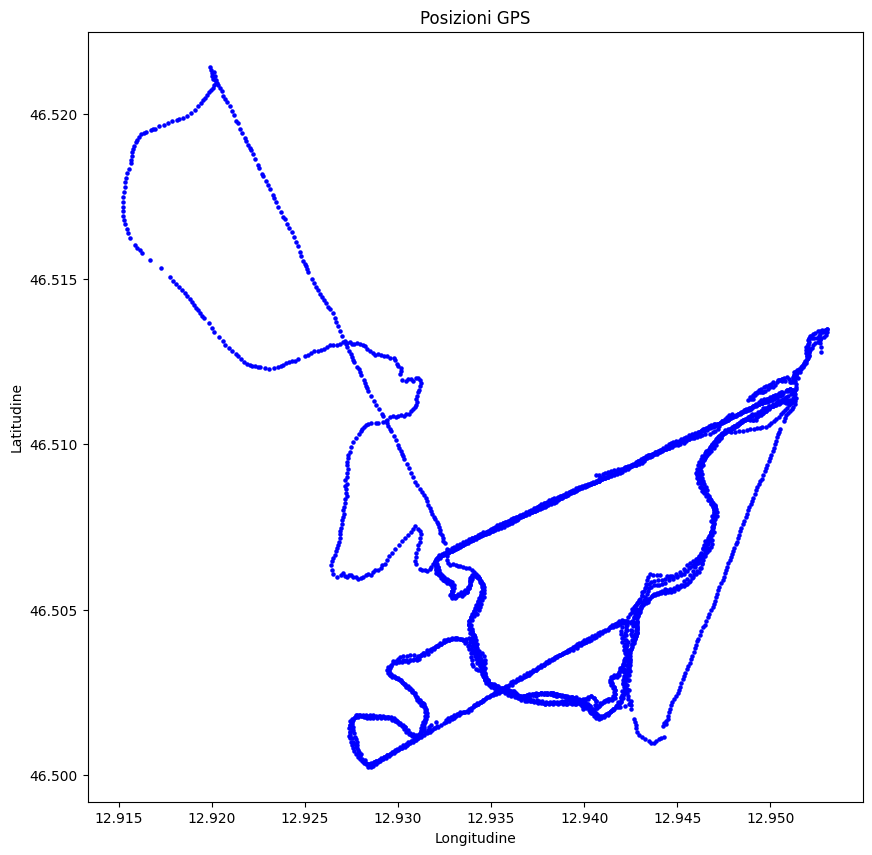

In [14]:


# Esempio di dati (usa i tuoi dati)
latitudini = gdf1['latitudine']
longitudini = gdf1['longitudine']

# Crea il grafico con uno sfondo bianco
plt.figure(figsize=(10, 10))
plt.scatter(longitudini, latitudini, color='blue', marker='o', s=5)  # s è la dimensione dei punti
plt.title("Posizioni GPS")
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
#plt.ylim(46.520, 46.525)

# Impostazioni per lo sfondo bianco 
plt.gca().set_facecolor('white')

plt.show()

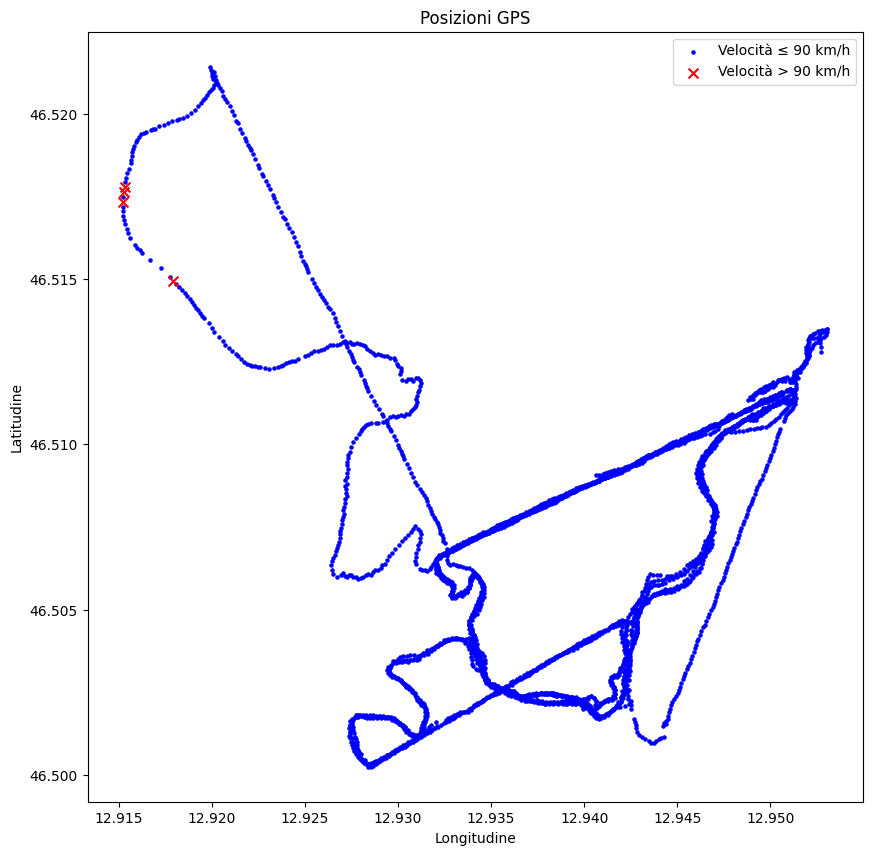

In [15]:
import matplotlib.pyplot as plt

# Esempio di dati (usa i tuoi dati)
latitudini = gdf1['latitudine']
longitudini = gdf1['longitudine']
velocita = gdf1['velocita']  # Assicurati che la velocità sia in m/s

# Crea il grafico con uno sfondo bianco
plt.figure(figsize=(10, 10))

# Plot dei punti normali (velocità <= 25 m/s)
plt.scatter(longitudini[velocita <= 25], latitudini[velocita <= 25], color='blue', marker='o', s=5, label='Velocità ≤ 90 km/h')

# Plot dei punti con velocità > 25 m/s (90 km/h) come croci rosse
plt.scatter(longitudini[velocita > 25], latitudini[velocita > 25], color='red', marker='x', s=50, label='Velocità > 90 km/h')

# Aggiungi titolo e etichette
plt.title("Posizioni GPS")
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")

# Impostazioni per lo sfondo bianco
plt.gca().set_facecolor('white')

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.show()

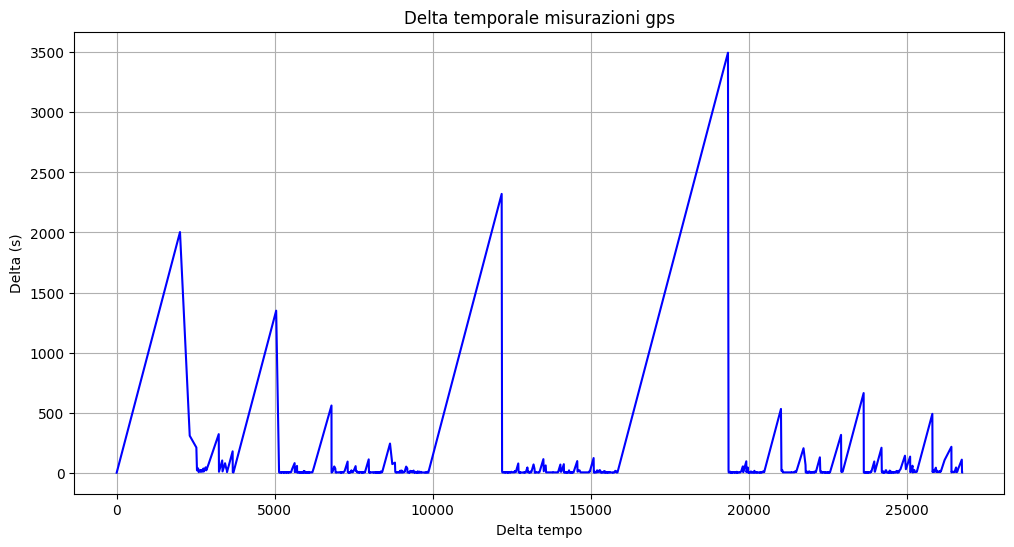

count    3167.000000
mean        8.449015
std        89.532255
min         0.000000
25%         2.000000
50%         2.996000
75%         3.002000
max      3496.265000
Name: delta_tempo, dtype: float64

In [16]:
## Delta tempo


plt.figure(figsize=(12, 6))
plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['delta_tempo'], 
    label='Intervallo di tempo tra misurazioni', 
    color='blue'
    )

plt.xlabel('Delta tempo')
plt.ylabel('Delta (s)')
plt.title('Delta temporale misurazioni gps')
plt.grid(True)
#plt.ylim(0, 600)  ## max 600 secondi-> 10 minuti di pausa
#plt.xlim(12000, 16500)

plt.show()

gdf1["delta_tempo"].describe()


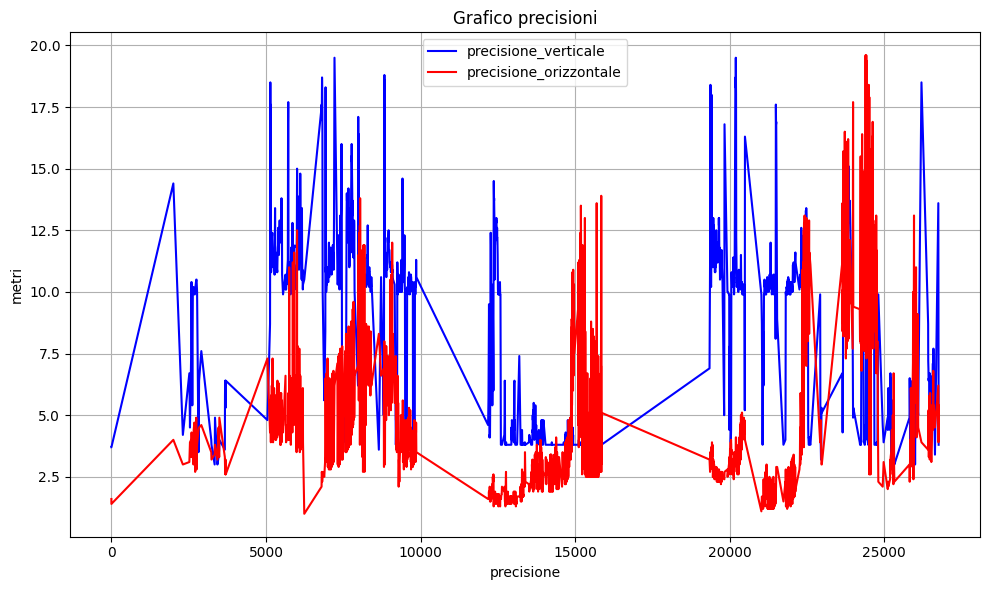

In [17]:
## Altimetria della giornata


plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['precisione_verticale'], 
    label='precisione_verticale', 
    color='blue')

plt.plot(
    gdf1['unixtime'] - time_start, 
    gdf1['precisione_orizzontale'], 
    label='precisione_orizzontale', 
    color='red'
)

plt.xlabel('precisione')
plt.ylabel('metri')
plt.title('Grafico precisioni')
plt.grid(True)
plt.legend()
#plt.ylim(0,50)

# Mostrare il grafico
plt.tight_layout()
plt.show()


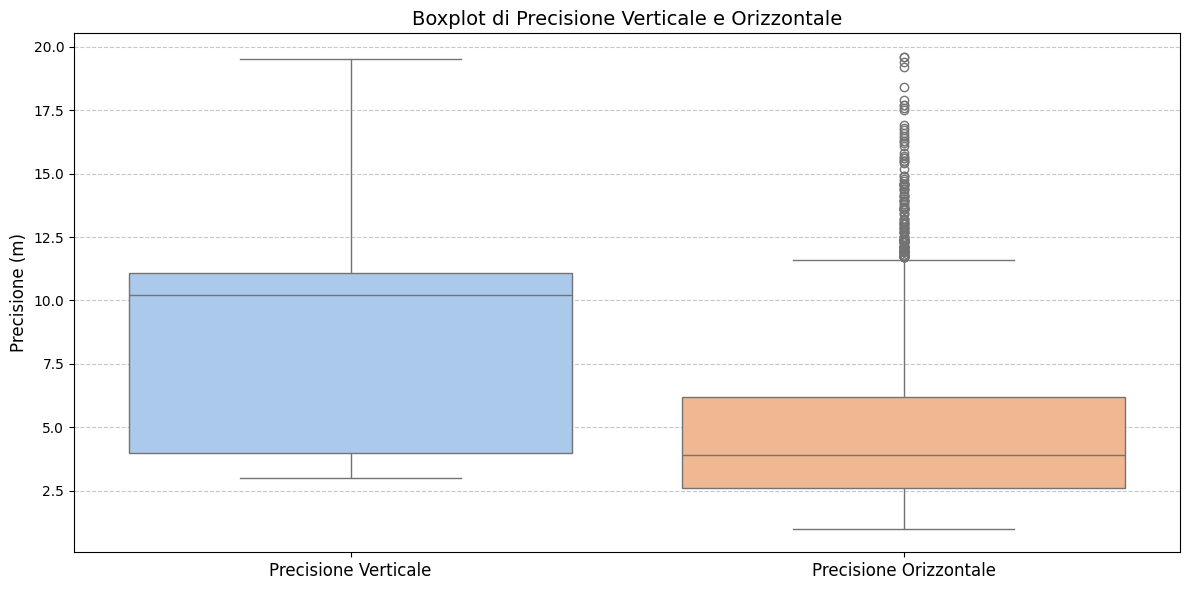

In [18]:
plt.figure(figsize=(12, 6))

# Crea i boxplot affiancati
sns.boxplot(data=gdf1[['precisione_verticale', 'precisione_orizzontale']], palette='pastel')

# Aggiungi titolo e etichette
plt.title('Boxplot di Precisione Verticale e Orizzontale', fontsize=14)
plt.ylabel('Precisione (m)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Precisione Verticale', 'Precisione Orizzontale'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.tight_layout()
plt.show()


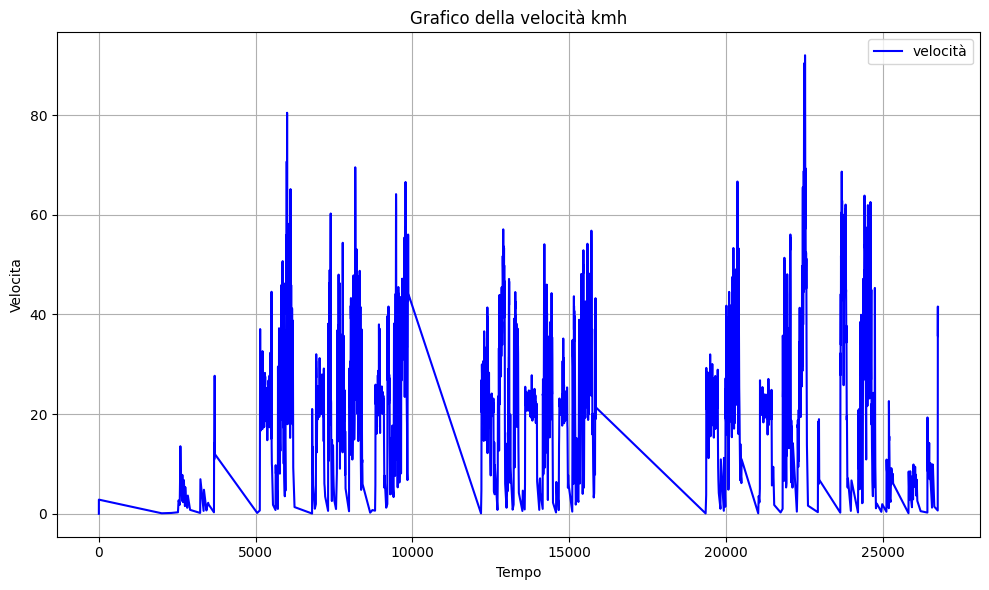

In [19]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['velocita'] * 3.6, 
    label='velocità', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Velocita')
plt.title('Grafico della velocità kmh')
plt.grid(True)
plt.legend()
#plt.ylim(0,200)
#plt.xlim(24300, 24600)  ## max 600 secondi-> 10 minuti di pausa

# Mostrare il grafico
plt.tight_layout()
plt.show()

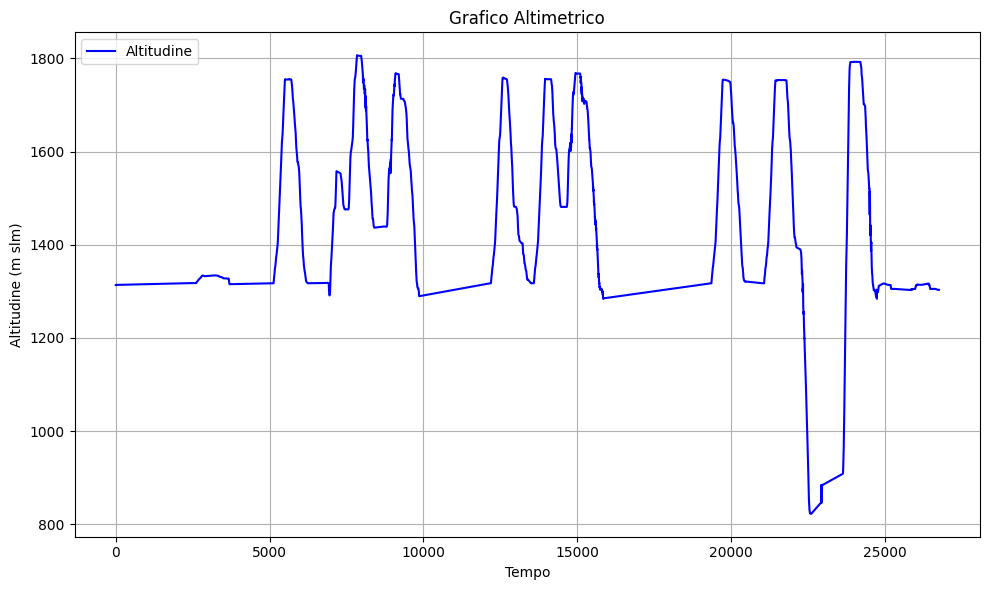

In [20]:
## Altimetria della giornata


plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['altitudine'], 
    label='Altitudine', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')
plt.title('Grafico Altimetrico')
plt.grid(True)
plt.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()


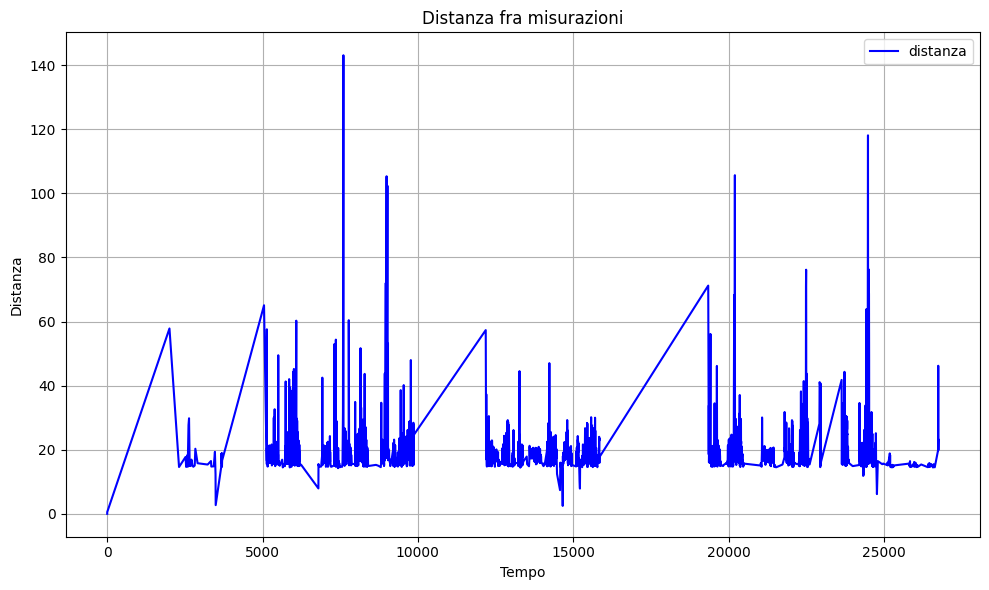

In [21]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['distanza_reale'], 
    label='distanza', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Distanza')
plt.title('Distanza fra misurazioni')
plt.grid(True)
plt.legend()
#plt.ylim(0,200)
#plt.xlim(24300, 24600)  ## max 600 secondi-> 10 minuti di pausa

# Mostrare il grafico
plt.tight_layout()
plt.show()

In [22]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import branca.colormap as cm

# Assumo che il tuo GeoDataFrame sia già caricato in gdf1
# Centra la mappa sulla media delle coordinate
mappa = folium.Map(
    location=[gdf1['latitudine'].mean(), gdf1['longitudine'].mean()],
    zoom_start=12
)

# Crea una scala di colori per la velocità
colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    vmin=gdf1['velocita'].min(),
    vmax=gdf1['velocita'].max()
)

# Aggiungi punti alla mappa
for _, row in gdf1.iterrows():
    folium.CircleMarker(
        location=[row['latitudine'], row['longitudine']],
        radius=5,
        color=colormap(row['velocita']),
        fill=True,
        fill_color=colormap(row['velocita']),
        fill_opacity=0.7,
        popup=f"Velocità: {row['velocita']} m/s"
    ).add_to(mappa)

# Aggiungi una linea tra i punti per visualizzare il percorso
folium.PolyLine(
    locations=gdf1[['latitudine', 'longitudine']].values.tolist(),
    color="blue",
    weight=2.5,
    opacity=0.7
).add_to(mappa)

# Aggiungi la scala colori alla mappa
colormap.caption = "Velocità (m/s)"
mappa.add_child(colormap)

# Salva la mappa e visualizzala
mappa.save("mappa.html")
mappa
